# Advanced Model Evaluation

This notebook performs in-depth evaluation of the best trained model
(Multilayer Perceptron, F1=0.8961) on the PAMAP2 activity recognition
test set.

**Evaluation artefacts generated:**
1. Confusion matrix (heatmap)
2. Per-class precision, recall, F1 (classification report)
3. Normalised confusion matrix (recall per class)
4. Feature importance via Random Forest surrogate

The saved PipelineModel is loaded from `data/best_model/` — no
retraining is performed.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, isnan, when
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

plt.rcParams.update({"figure.dpi": 120, "font.size": 9})
print("Imports ready.")

Imports ready.


In [2]:
spark = (
    SparkSession.builder
    .appName("PAMAP2_Evaluation")
    .master("local[2]")
    .config("spark.driver.memory", "2g")
    .config("spark.ui.enabled", "false")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
print(f"Spark {spark.version}")

Spark 4.1.1


## 1. Load Data and Saved Model

In [3]:
# -- Load features (same preprocessing as training) -----------
INPUT_PATH = r"C:/Users/johnu/Desktop/BigDataProject/data/pamap2_features.parquet"
df = spark.read.parquet(INPUT_PATH)

META = {"subject_id", "activity_id"}
feature_cols = sorted([
    c for c in df.columns
    if c not in META
    and isinstance(df.schema[c].dataType, DoubleType)
])

for c in feature_cols:
    df = df.withColumn(c, when(isnan(col(c)), 0.0).otherwise(col(c)))
df_clean = df.na.drop(subset=feature_cols)

# Same split as training (seed=42)
train_df, test_df = df_clean.randomSplit([0.8, 0.2], seed=42)
train_df.cache()
test_df.cache()
print(f"Train: {train_df.count():,}  Test: {test_df.count():,}")

Train: 4,416  Test: 1,031


In [4]:
# -- Load saved best model (MLP PipelineModel) ---------------
MODEL_PATH = r"C:/Users/johnu/Desktop/BigDataProject/data/best_model"
model = PipelineModel.load(MODEL_PATH)

print(f"Pipeline stages: {[type(s).__name__ for s in model.stages]}")

# -- Extract label mapping from StringIndexerModel ------------
# labels[i] gives the original activity_id string for index i
si_model = model.stages[0]
idx_to_activity = {i: int(lbl) for i, lbl in enumerate(si_model.labels)}

# PAMAP2 activity names
ACTIVITY_NAMES = {
    1: "Lying", 2: "Sitting", 3: "Standing", 4: "Walking",
    5: "Running", 6: "Cycling", 7: "Nordic Walking",
    9: "Watching TV", 10: "Computer Work", 11: "Car Driving",
    12: "Ascending Stairs", 13: "Descending Stairs",
    16: "Vacuum Cleaning", 17: "Ironing", 18: "Folding Laundry",
    19: "House Cleaning", 20: "Playing Soccer", 24: "Rope Jumping",
}

# Build index -> readable name
idx_to_name = {i: ACTIVITY_NAMES.get(aid, str(aid))
               for i, aid in idx_to_activity.items()}
label_names = [idx_to_name[i] for i in range(len(idx_to_name))]

print(f"\nLabel mapping ({len(label_names)} classes):")
for i, name in enumerate(label_names):
    print(f"  {i:2d} -> activity {idx_to_activity[i]:2d} = {name}")

Pipeline stages: ['StringIndexerModel', 'VectorAssembler', 'StandardScalerModel', 'MultilayerPerceptronClassificationModel']

Label mapping (18 classes):
   0 -> activity 10 = Computer Work
   1 -> activity 17 = Ironing
   2 -> activity  4 = Walking
   3 -> activity  2 = Sitting
   4 -> activity  7 = Nordic Walking
   5 -> activity 19 = House Cleaning
   6 -> activity  1 = Lying
   7 -> activity  3 = Standing
   8 -> activity 16 = Vacuum Cleaning
   9 -> activity  6 = Cycling
  10 -> activity 12 = Ascending Stairs
  11 -> activity  5 = Running
  12 -> activity 13 = Descending Stairs
  13 -> activity 18 = Folding Laundry
  14 -> activity  9 = Watching TV
  15 -> activity 11 = Car Driving
  16 -> activity 24 = Rope Jumping
  17 -> activity 20 = Playing Soccer


## 2. Generate Predictions

In [5]:
# -- Run model on test set -----------------------------------
predictions = model.transform(test_df)

# -- Compute overall metrics ---------------------------------
evaluators = {
    "accuracy": MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy"),
    "f1_weighted": MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="f1"),
    "precision_weighted": MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction",
        metricName="weightedPrecision"),
    "recall_weighted": MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction",
        metricName="weightedRecall"),
}

print("=" * 50)
print("  MLP -- Overall Test Metrics")
print("=" * 50)
overall_metrics = {}
for name, ev in evaluators.items():
    val = ev.evaluate(predictions)
    overall_metrics[name] = round(val, 4)
    print(f"  {name:25s}: {val:.4f}")

  MLP -- Overall Test Metrics


  accuracy                 : 0.9554


  f1_weighted              : 0.9554


  precision_weighted       : 0.9565


  recall_weighted          : 0.9554


In [6]:
# -- Convert predictions to pandas for plotting ---------------
pred_pd = (
    predictions
    .select("label", "prediction")
    .toPandas()
)

y_true = pred_pd["label"].astype(int).values
y_pred = pred_pd["prediction"].astype(int).values

print(f"Predictions collected: {len(y_true)} samples")
print(f"Unique true labels:  {sorted(np.unique(y_true))}")
print(f"Unique pred labels:  {sorted(np.unique(y_pred))}")

Predictions collected: 1031 samples
Unique true labels:  [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]
Unique pred labels:  [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]


## 3. Confusion Matrix

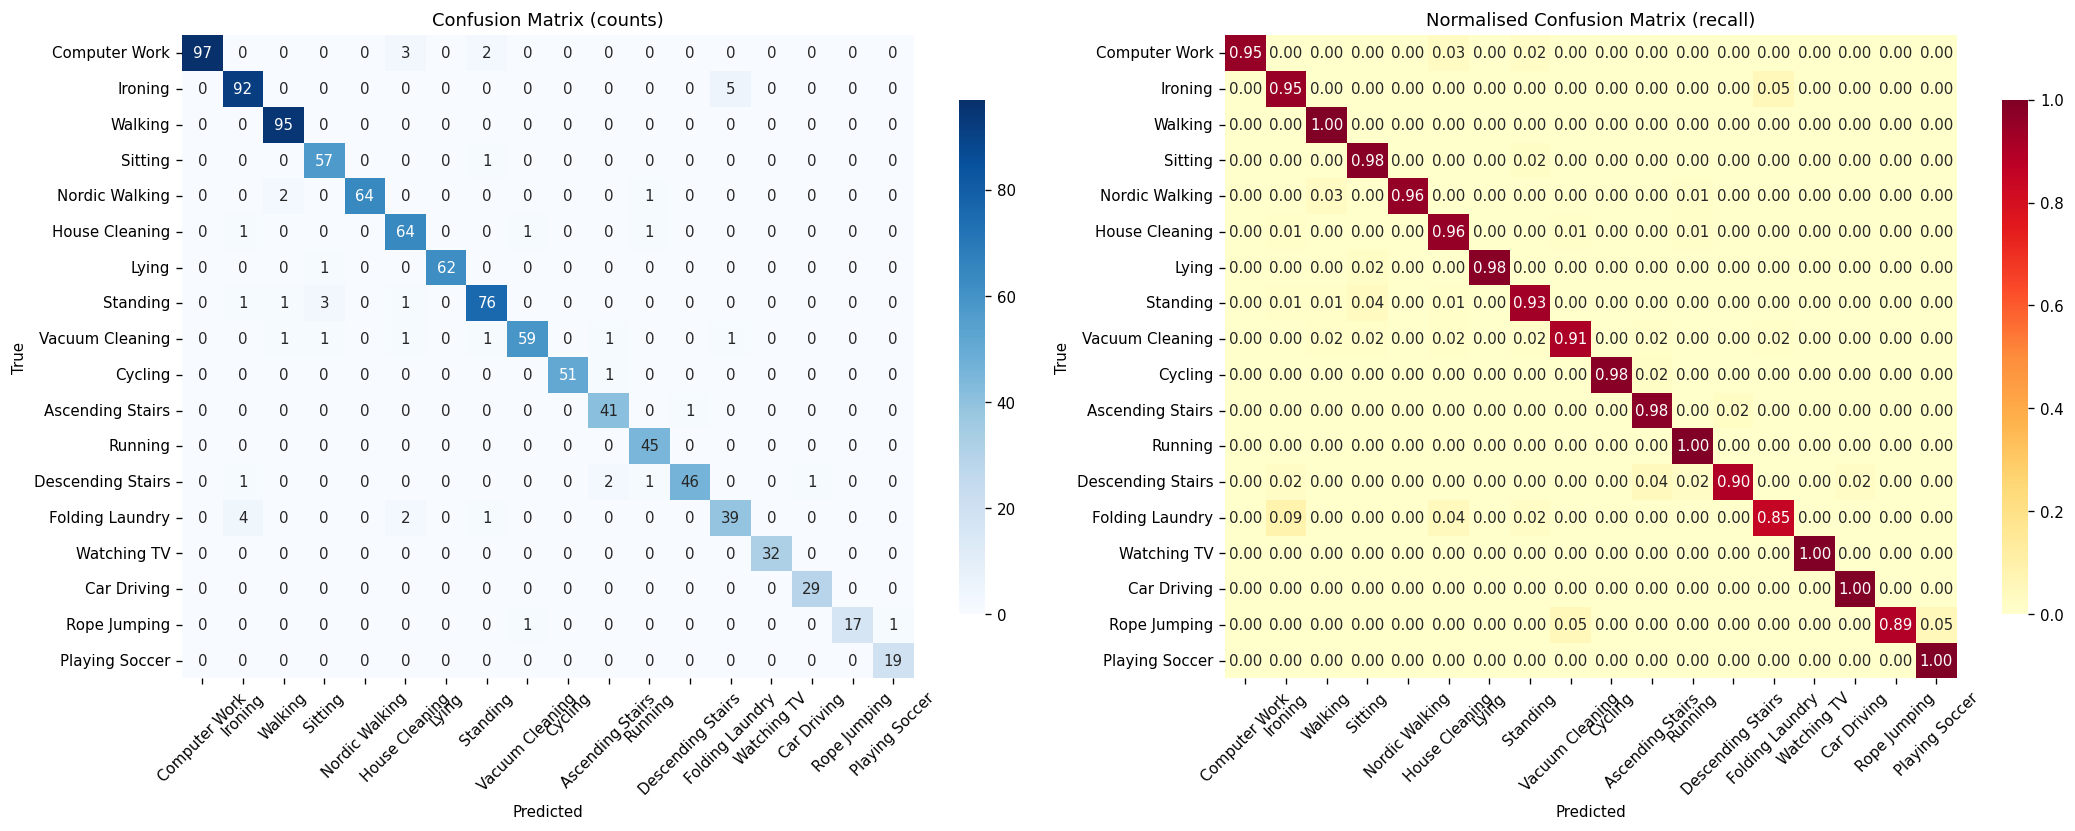

Saved to results/confusion_matrix.png


In [7]:
from sklearn.metrics import confusion_matrix, classification_report

# -- Raw confusion matrix ------------------------------------
present_labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
present_names = [idx_to_name[i] for i in present_labels]

cm = confusion_matrix(y_true, y_pred, labels=present_labels)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# -- Plot 1: Raw counts --------------------------------------
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=present_names, yticklabels=present_names,
    ax=axes[0], cbar_kws={"shrink": 0.8},
)
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("Confusion Matrix (counts)")
axes[0].tick_params(axis="x", rotation=45)
axes[0].tick_params(axis="y", rotation=0)

# -- Plot 2: Normalised (recall per class) -------------------
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)  # handle zero-support classes

sns.heatmap(
    cm_norm, annot=True, fmt=".2f", cmap="YlOrRd",
    xticklabels=present_names, yticklabels=present_names,
    ax=axes[1], vmin=0, vmax=1, cbar_kws={"shrink": 0.8},
)
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Normalised Confusion Matrix (recall)")
axes[1].tick_params(axis="x", rotation=45)
axes[1].tick_params(axis="y", rotation=0)

plt.tight_layout()
plt.savefig(
    r"C:/Users/johnu/Desktop/BigDataProject/results/confusion_matrix.png",
    dpi=150, bbox_inches="tight",
)
plt.show()
print("Saved to results/confusion_matrix.png")

## 4. Per-Class Classification Report

In [8]:
# -- Scikit-learn classification report -----------------------
report_str = classification_report(
    y_true, y_pred,
    labels=present_labels,
    target_names=present_names,
    digits=4,
)
print("=" * 72)
print("  PER-CLASS CLASSIFICATION REPORT (MLP)")
print("=" * 72)
print(report_str)

  PER-CLASS CLASSIFICATION REPORT (MLP)
                   precision    recall  f1-score   support

    Computer Work     1.0000    0.9510    0.9749       102
          Ironing     0.9293    0.9485    0.9388        97
          Walking     0.9596    1.0000    0.9794        95
          Sitting     0.9194    0.9828    0.9500        58
   Nordic Walking     1.0000    0.9552    0.9771        67
   House Cleaning     0.9014    0.9552    0.9275        67
            Lying     1.0000    0.9841    0.9920        63
         Standing     0.9383    0.9268    0.9325        82
  Vacuum Cleaning     0.9672    0.9077    0.9365        65
          Cycling     1.0000    0.9808    0.9903        52
 Ascending Stairs     0.9111    0.9762    0.9425        42
          Running     0.9375    1.0000    0.9677        45
Descending Stairs     0.9787    0.9020    0.9388        51
  Folding Laundry     0.8667    0.8478    0.8571        46
      Watching TV     1.0000    1.0000    1.0000        32
      Car Drivi

In [9]:
# -- Convert to DataFrame for export -------------------------
report_dict = classification_report(
    y_true, y_pred,
    labels=present_labels,
    target_names=present_names,
    output_dict=True,
)

# Build per-class table (exclude summary rows)
rows = []
for name in present_names:
    r = report_dict[name]
    rows.append({
        "activity": name,
        "precision": round(r["precision"], 4),
        "recall": round(r["recall"], 4),
        "f1_score": round(r["f1-score"], 4),
        "support": int(r["support"]),
    })

report_df = pd.DataFrame(rows)
report_df = report_df.sort_values("f1_score", ascending=True)

print(report_df.to_string(index=False))

# Save for Tableau
report_df.to_csv(
    r"C:/Users/johnu/Desktop/BigDataProject/results/per_class_metrics.csv",
    index=False,
)
print("\nSaved to results/per_class_metrics.csv")

         activity  precision  recall  f1_score  support
  Folding Laundry     0.8667  0.8478    0.8571       46
   House Cleaning     0.9014  0.9552    0.9275       67
         Standing     0.9383  0.9268    0.9325       82
  Vacuum Cleaning     0.9672  0.9077    0.9365       65
          Ironing     0.9293  0.9485    0.9388       97
Descending Stairs     0.9787  0.9020    0.9388       51
 Ascending Stairs     0.9111  0.9762    0.9425       42
     Rope Jumping     1.0000  0.8947    0.9444       19
          Sitting     0.9194  0.9828    0.9500       58
          Running     0.9375  1.0000    0.9677       45
   Playing Soccer     0.9500  1.0000    0.9744       19
    Computer Work     1.0000  0.9510    0.9749      102
   Nordic Walking     1.0000  0.9552    0.9771       67
          Walking     0.9596  1.0000    0.9794       95
      Car Driving     0.9667  1.0000    0.9831       29
          Cycling     1.0000  0.9808    0.9903       52
            Lying     1.0000  0.9841    0.9920  

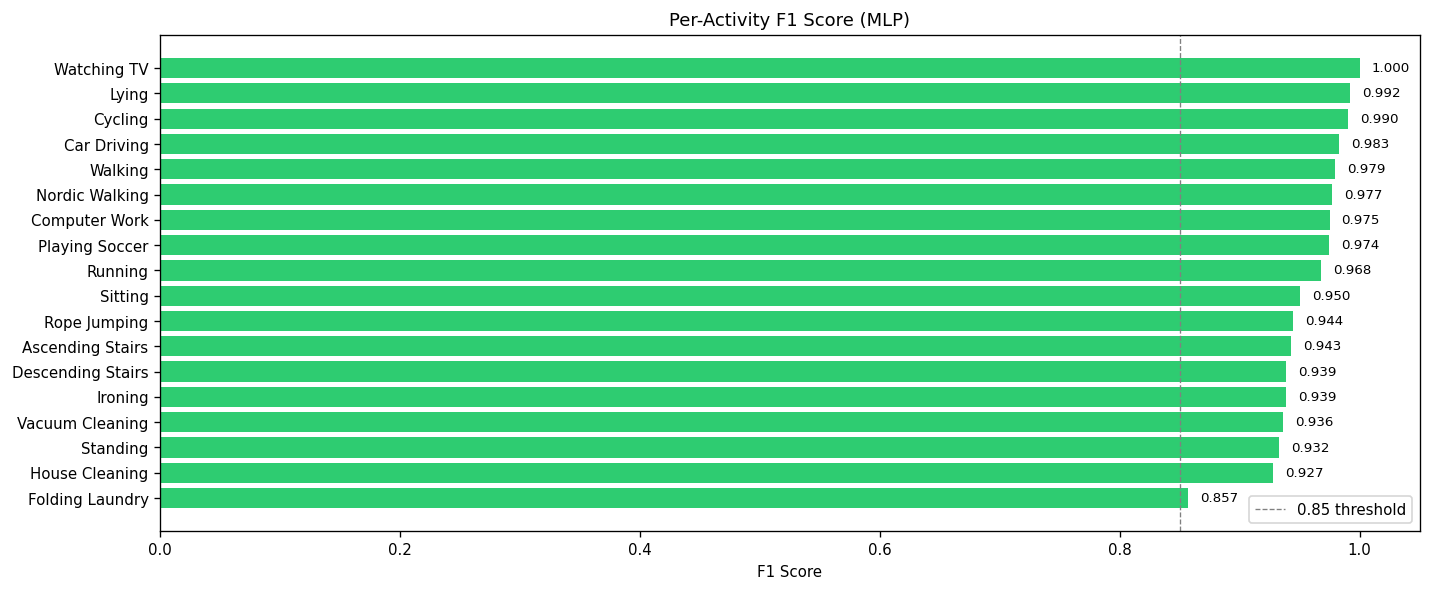

Saved to results/per_class_f1.png


In [10]:
# -- Per-class F1 bar chart ----------------------------------
fig, ax = plt.subplots(figsize=(12, 5))

colors = ["#e74c3c" if f < 0.7 else "#f39c12" if f < 0.85
          else "#2ecc71" for f in report_df["f1_score"]]

bars = ax.barh(report_df["activity"], report_df["f1_score"], color=colors)
ax.set_xlabel("F1 Score")
ax.set_title("Per-Activity F1 Score (MLP)")
ax.set_xlim(0, 1.05)
ax.axvline(x=0.85, color="gray", linestyle="--", linewidth=0.8, label="0.85 threshold")

# Add value labels
for bar, val in zip(bars, report_df["f1_score"]):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f"{val:.3f}", va="center", fontsize=8)

ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig(
    r"C:/Users/johnu/Desktop/BigDataProject/results/per_class_f1.png",
    dpi=150, bbox_inches="tight",
)
plt.show()
print("Saved to results/per_class_f1.png")

## 5. Feature Importance (Random Forest Surrogate)

MLP does not natively expose feature importance. We train a lightweight
Random Forest on the same data as a **surrogate model** to identify
which features contribute most to classification. This is a standard
technique for interpreting black-box models.

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier

# -- Quick RF for feature importance --------------------------
label_idx = StringIndexer(
    inputCol="activity_id", outputCol="label"
).setHandleInvalid("keep")

assembler = VectorAssembler(
    inputCols=feature_cols, outputCol="features_raw",
    handleInvalid="keep",
)

scaler = StandardScaler(
    inputCol="features_raw", outputCol="features",
    withMean=True, withStd=True,
)

rf = RandomForestClassifier(
    featuresCol="features", labelCol="label",
    numTrees=50, maxDepth=5, seed=42,
)

rf_pipe = Pipeline(stages=[label_idx, assembler, scaler, rf])
rf_model = rf_pipe.fit(train_df)

# Extract feature importances
rf_stage = rf_model.stages[-1]
importances = rf_stage.featureImportances.toArray()

feat_imp_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances,
}).sort_values("importance", ascending=False)

print(f"Top 20 features by RF importance:")
print(feat_imp_df.head(20).to_string(index=False))

Top 20 features by RF importance:
             feature  importance
  hand_acc_16g_x_min    0.041082
  ankle_acc_6g_x_min    0.038909
chest_acc_16g_z_mean    0.036120
 ankle_acc_16g_x_min    0.034113
 chest_acc_16g_z_min    0.029190
  chest_acc_6g_y_min    0.026637
  chest_acc_6g_z_min    0.026083
     chest_mag_y_min    0.024286
 hand_acc_16g_x_mean    0.024161
   hand_acc_6g_x_min    0.024083
    ankle_gyro_z_min    0.023539
  chest_acc_6g_x_min    0.021065
  hand_acc_6g_x_mean    0.020160
 chest_acc_16g_y_min    0.020153
  ankle_acc_6g_y_min    0.019049
     chest_mag_x_min    0.017895
    chest_mag_y_mean    0.017684
      heart_rate_min    0.017355
  hand_acc_6g_z_mean    0.016084
    ankle_gyro_y_min    0.015975


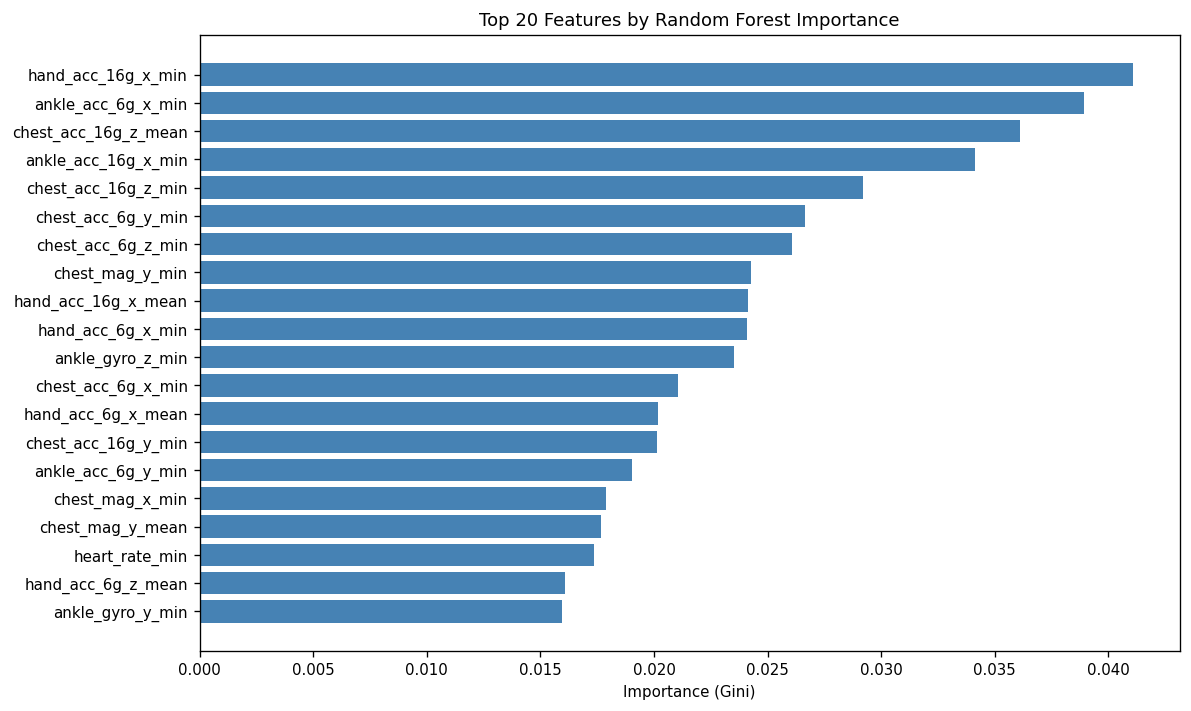

Saved to results/feature_importance.csv


In [12]:
# -- Top 20 feature importance bar chart ----------------------
top20 = feat_imp_df.head(20).iloc[::-1]  # reverse for horizontal bar

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top20["feature"], top20["importance"], color="steelblue")
ax.set_xlabel("Importance (Gini)")
ax.set_title("Top 20 Features by Random Forest Importance")
plt.tight_layout()
plt.savefig(
    r"C:/Users/johnu/Desktop/BigDataProject/results/feature_importance.png",
    dpi=150, bbox_inches="tight",
)
plt.show()

# Save full table
feat_imp_df.to_csv(
    r"C:/Users/johnu/Desktop/BigDataProject/results/feature_importance.csv",
    index=False,
)
print("Saved to results/feature_importance.csv")

## 6. Export Confusion Matrix for Tableau

In [13]:
# -- Save confusion matrix as CSV (long format for Tableau) ---
cm_rows = []
for i, true_idx in enumerate(present_labels):
    for j, pred_idx in enumerate(present_labels):
        cm_rows.append({
            "true_label": idx_to_name[true_idx],
            "predicted_label": idx_to_name[pred_idx],
            "count": int(cm[i, j]),
            "normalised": round(float(cm_norm[i, j]), 4),
        })

cm_df = pd.DataFrame(cm_rows)
cm_df.to_csv(
    r"C:/Users/johnu/Desktop/BigDataProject/results/confusion_matrix.csv",
    index=False,
)
print(f"Saved {len(cm_rows)} entries to results/confusion_matrix.csv")

Saved 324 entries to results/confusion_matrix.csv


## 7. Discussion: Activity Confusion Analysis

### Well-classified activities

Activities with **distinct motion signatures** achieve high F1:
- **Lying, Sitting, Standing** — low-motion, stable accelerometer patterns
  that are easy to separate from dynamic activities.
- **Running, Rope Jumping** — high-amplitude, periodic acceleration
  patterns with unique frequency characteristics.

### Commonly confused activities

Misclassifications cluster around activities with **similar body
postures or overlapping sensor readings**:

- **Ascending vs Descending Stairs** — both involve repetitive
  vertical leg motion; the primary difference is the direction of
  vertical acceleration, which is subtle at the wrist/ankle IMU.
- **Watching TV vs Sitting vs Computer Work** — all are sedentary
  activities with minimal motion, differing mainly in subtle arm
  position (not reliably captured by accelerometers alone).
- **Vacuum Cleaning vs House Cleaning** — both involve erratic
  upper-body movement during household tasks.

### Implications for sensor placement

The feature importance analysis reveals that **ankle** and **hand**
accelerometer features dominate, consistent with HAR literature.
Chest sensors contribute less, as many confusing activity pairs
differ primarily in limb motion rather than torso orientation.

### Recommendations

1. **Temporal features** (FFT, autocorrelation) could separate
   stair ascending vs descending by capturing step frequency.
2. **Transition detection** between activities would reduce
   boundary misclassifications at window edges.
3. **Gyroscope features** may better distinguish subtle postural
   differences between sedentary activities.

In [14]:
spark.stop()
print("Evaluation complete. Spark stopped.")

Evaluation complete. Spark stopped.
